In [1]:
%pylab inline
%load_ext rpy2.ipython

Populating the interactive namespace from numpy and matplotlib


In [2]:
%%R
library(ggplot2)
library(ggthemes)
my_theme = theme_hc() +
    theme(
        axis.text=element_text(size=14),
        axis.title=element_text(size=16),
        plot.title=element_text(size=22))

In [3]:
import igraph
import py2neo
import pandas as pd
import numpy as np
import palettable as pal
from collections import Counter

In [4]:
neo = py2neo.Graph()

In [5]:
# Uncomment this query to not care about RSVPs (just membership)
# edges = neo.cypher.execute('''
# match (m:Member)-[:HAS_MEMBERSHIP]->(g:Group)
# return
#     m.id as member,
#     g.name as group
# ''')

edges = neo.cypher.execute('''
match (m:Member)-[r:RSVP_ED]->(:Event)<-[:ORGANISED]-(g:Group)
where r.response = 'yes'
return
    m.id as member,
    g.name as group
''')

len(edges)

4117

In [6]:
# Uncomment this query to not care about RSVPs (just membership)
# nodes = neo.cypher.execute('''
# match (m:Member)-[:HAS_MEMBERSHIP]->(g:Group)
# return
#     distinct m.id as name, 'member' as kind
# union all match (g:Group)
# return
#     g.name as name, 'group' as kind
# ''')

nodes = neo.cypher.execute('''
match (m:Member)-[r:RSVP_ED]->(:Event)<-[:ORGANISED]-(g:Group)
where r.response = 'yes'
return
    distinct m.id as name, 'member' as kind
union all match (:Member)-[:RSVP_ED]->(:Event)<-[:ORGANISED]-(g:Group)
return
    distinct g.name as name, 'group' as kind
''')

len(nodes)

1845

In [7]:
graph = igraph.Graph()

nodes_lookup = {
    node.name: ig_node_id
    for (ig_node_id, node) in zip(range(len(nodes)), nodes)
}

for node in nodes:
    graph.add_vertex(name=node.name, kind=node.kind)

graph.add_edges([(nodes_lookup[edge.member], nodes_lookup[edge.group]) for edge in edges])

In [8]:
# Uncomment this query to not care about RSVPs (just membership)
# community_nodes = neo.cypher.execute('''
# match (m:Member)-[:HAS_MEMBERSHIP]->(g:Group)
# return
#     distinct m.id as name
# ''')

community_nodes = neo.cypher.execute('''
match (m:Member)-[r:RSVP_ED]->(:Event)<-[:ORGANISED]-(g:Group)
where r.response = 'yes'
return
    distinct m.id as name
''')

len(community_nodes)

1832

In [9]:
# Uncomment this query to not care about RSVPs (just membership)
# community_edges = neo.cypher.execute('''
# match (m1:Member)-[:HAS_MEMBERSHIP]->(:Group)<-[:HAS_MEMBERSHIP]-(m2:Member)
# where ID(m1) < ID(m2)
# return
#     m1.id as left, m2.id as right, count(*) as cnt
# ''')

community_edges = neo.cypher.execute('''
match (m1:Member)-[r:RSVP_ED]->(:Event)<-[:ORGANISED]-(g:Group)
where r.response = "yes"
with m1, g
match (m2:Member)-[r:RSVP_ED]->(:Event)<-[:ORGANISED]-(g)
where r.response = "yes" and ID(m1) < ID(m2)
return
    m1.id as left, m2.id as right, count(*) as cnt
''')

len(community_edges)

365479

In [10]:
community_graph = igraph.Graph()

community_nodes_lookup = {
    node.name: ig_node_id
    for (ig_node_id, node) in zip(range(len(community_nodes)), community_nodes)
}

for node in community_nodes:
    community_graph.add_vertex(name=node.name)

community_graph.add_edges([
        (community_nodes_lookup[edge.left], community_nodes_lookup[edge.right])
        for edge in community_edges])

community_graph.es['cnt'] = [e.cnt for e in community_edges]

In [11]:
communities = community_graph.community_fastgreedy(weights='cnt')

In [12]:
num_communities = max(communities.as_clustering().membership) + 1
num_communities

5

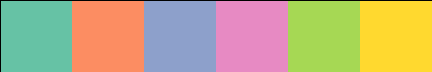

In [13]:
colors = pal.colorbrewer.qualitative.Set2_6
colors.show_discrete_image()

In [14]:
groups = graph.vs(kind='group')
groups['color'] = 'lightcoral'
groups['label_color'] = 'black'
groups['label_size'] = 10.
groups['label_dist'] = 1.2
groups['label_angle'] = 0
groups['label'] = groups['name']

max_group_degree = max([v.degree() for v in groups])
groups['size'] = [13 + (float(v.degree()) / max_group_degree) ** 2 * 25 for v in groups]

membership = communities.as_clustering().membership
members = graph.vs(kind='member')
members['color'] = [
        colors.hex_colors[membership[community_nodes_lookup[ m['name'] ]]]
        for m in members
    ]

members['community'] = [
        membership[community_nodes_lookup[ m['name'] ]]
        for m in members
    ]

members['frame_width'] = 0.
members['size'] = 4

graph.es['color'] = 'lightgray'
graph.es['width'] = 0.1

In [15]:
graph_layout = graph.layout_fruchterman_reingold(maxiter=2000)

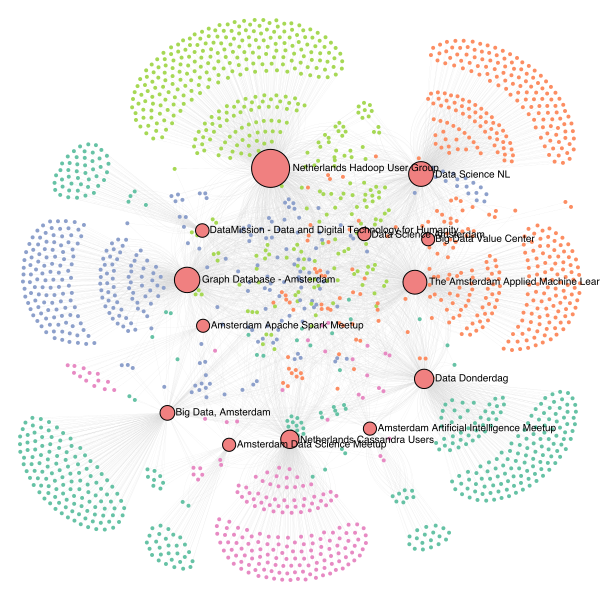

In [16]:
igraph.plot(graph, layout=graph_layout)

In [17]:
communities_df = pd.DataFrame([{
    'community': graph.vs[e.source]['community'],
    'group': graph.vs[e.target]['name']
} for e in graph.es], index=[graph.vs[e.source]['name'] for e in graph.es])

communities_df.head()

,community,group
69509122,0,"Big Data, Amsterdam"
69509122,0,Data Donderdag
185155588,0,"Big Data, Amsterdam"
81124012,1,Data Science NL
81124012,1,Data Science NL


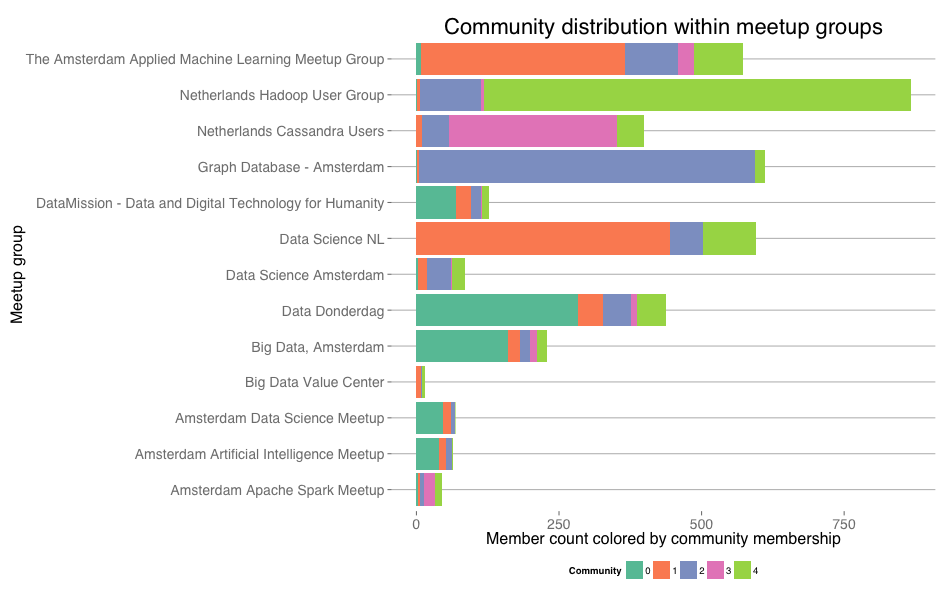

In [18]:
%%R -i communities_df -w 950 -h 600
ggplot(data=communities_df, aes(x=group, fill=as.factor(community))) +
geom_bar(stat='bin') +
scale_fill_brewer(palette="Set2") +
labs(
    title="Community distribution within meetup groups",
    x="Meetup group",
    y="Member count colored by community membership",
    fill="Community"
) +
coord_flip() +
my_theme

In [19]:
# Uncomment this query to not care about RSVPs (just membership)
# member_topics = neo.cypher.execute('''
# match (m:Member)-[:LIKES]->(t:Topic)
# return m.id as name, collect(t.name) as topics
# ''')

member_topics = neo.cypher.execute('''
match (:Event)<-[r:RSVP_ED]-(m:Member)-[:LIKES]->(t:Topic)
where r.response = 'yes'
return m.id as name, collect(t.name) as topics
''')

global_tf = Counter()
community_tf = [Counter() for ignored in range(num_communities)]

for mt in member_topics:
    global_tf.update(mt.topics)
    community_tf[graph.vs[nodes_lookup[mt.name]]['community']].update(mt.topics)
    
global_tf_df = pd.DataFrame({ 'freq': global_tf.values() }, index=global_tf.keys())
global_tf_df['P'] = global_tf_df['freq'] / np.sum(global_tf_df['freq'])
for c in range(num_communities):
    f = pd.DataFrame({ 'community-%d' % c: community_tf[c].values() }, index=community_tf[c].keys())
    f['P-community-%d' % c] = f['community-%d' % c] / np.sum(f['community-%d' % c])
    f['r-community-%d' % c] = f['P-community-%d' % c] / global_tf_df['P']
    global_tf_df = global_tf_df.join(f[ ['community-%d' % c, 'r-community-%d' % c] ])

global_tf_df.dropna().head()

,freq,P,community-0,r-community-0,community-1,r-community-1,community-2,r-community-2,community-3,r-community-3,community-4,r-community-4
NoSQL,1499,0.022101,64,0.363058,167,0.491007,517,1.046119,187,1.656103,564,1.502080
Django,132,0.001946,1,0.064421,49,1.636045,69,1.585504,2,0.201142,11,0.332686
Collaboration,20,0.000295,6,2.551053,8,1.762922,2,0.303314,3,1.991309,1,0.199612
Website Optimization,33,0.000487,3,0.773046,2,0.267109,16,1.470612,9,3.620563,3,0.362930
AngularJS,18,0.000265,4,1.889669,5,1.224251,4,0.674031,1,0.737522,4,0.887162


In [20]:
for c in range(num_communities):
    print 'Community %d' % c
    print global_tf_df.dropna().sort('r-community-%d' % c, ascending=False)['r-community-%d' % c].head(20)
    print

Community 0
Positive Thinking       4.251755
Digital Marketing       4.251755
Graphic Design          4.152877
Knowledge Sharing       4.066896
Inspirational           3.968305
JQuery                  3.501446
Leadership              3.464393
Sci-Fi/Fantasy          3.447369
Cycling                 3.365973
Investing               3.306921
Business Development    3.239433
Film                    3.107052
Communication Skills    3.092186
Water Sports            3.001239
Geek Culture            2.943523
Reading                 2.834504
Japanese Culture        2.834504
Game Night              2.768585
E-Commerce              2.765369
Online Marketing        2.746921
Name: r-community-0, dtype: float64

Community 1
Creative Industries        2.693352
Camping                    2.551597
Literature                 2.312028
Creative Writing           2.285269
Psychology                 2.203652
Information Technology     2.122035
IT Professionals           2.098716
20's & 30's Social         